In [1]:
%matplotlib notebook

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

<hr style="border-width:4px; border-color:coral"/>

# Set example

<hr style="border-width:4px; border-color:coral"/>

In [3]:
ex_list = ['swirl','acoustics','radialdam','shockbubble']

# ratio of advance_step2 to nvprof reported time in cudaclaw_flux2_and_update_batch
# 100 steps of each code (advance_step2, nvprof_time)

nvidia_factors = {'radialdam'  : (34.0728,20.7257), 'swirl'     : (2.48783,1.54757), \
                 'shockbubble' : (10.7283,8.06588), 'acoustics' : (19.7589,11.6447)}

example = ex_list[3]

<hr style="border-width:4px; border-color:coral"/>

# Data Tools (file)

<hr style="border-width:4px; border-color:coral"/>

In [4]:
%%file data_tools.py
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab20').colors

amr_colors = {'advance' : (cmap[0:2]),     # blue
              'ghost'   : (cmap[2:4]),     # orange
              'regrid'  : (cmap[4:6]),     # green
              'comm'    : (cmap[6:8]),     # red
              'memcopy' : (cmap[8:10]),    # purple
              'other'   : (cmap[10:12]),   # brown
              'extra1'  : (cmap[12:14]),   # pink
              'extra2'  : (cmap[14:16]),   # grey
              'extra3'  : (cmap[16:18]),   # light green
              'extra4'  : (cmap[18:20])}   # tourquoise
  
    
cols = ['walltime','advance','ghostfill','regrid','adapt',
            'adv_steps','adv_step2', 'mx', 'patch_comm', 'output', 'grids_proc',
            'memcopy_h2h','memcopy_h2d','memcopy_d2h']

    
dtypes = {'walltime': float,
          'advance': float,
          'ghostfill': float,
          'regrid': float,
          'adapt': float,
          'adv_steps': int,
          'adv_step2': int,
          'mx': int,
          'patch_comm': float,
          'output' : float,
          'grids_proc' : int,          
          'memcopy_h2h': float,
          'memcopy_h2d': float,
          'memcopy_d2h': float}    

def read_data(dir,device):
    fname = os.path.join('{:s}'.format(dir),'{:s}'.format(device),'results.out')
    df = pandas.read_table(fname,delim_whitespace=True)
    df.sort_values('p',inplace=True)

    f = '{:.2f}'.format
    fstr = {'p' : '{:3d}'.format,
            'walltime' : f,
            'advance' : f,
            'ghostfill' : f, 
            'patch_comm' : f,
            'regrid' : f, 
            'partition' : f,
            'adapt' : f,             
            'cfl' : f, 
            'grids_proc' : '{:4d}'.format, 
            'DOF/s' : '{:.1e}'.format,
            'Speedup': '{:.1f}'.format, 
            'Eff.' : '{:.1f}%'.format, 
            'output':'{:.1f}'.format,
            'memcopy_h2h' : '{:.2f}'.format, 
            'memcopy_d2h' : '{:.2f}'.format,
            'memcopy_h2d' : '{:.2f}'.format}

    return df,fstr

def strong_scaling(df,field='walltime'):
    procs = df.index.get_level_values(0).values
    y = df[field].values
    plt.loglog(procs,y,'.-',markersize=15,label=field.capitalize())

    # Plot best-fit speed-up line
    t_strong = np.array(df[field].values)
    c = np.polyfit(np.log(procs[:-1]),np.log(t_strong[:-1]),1)
    plt.loglog(procs,np.exp(np.polyval(c,np.log(procs))),'r-',label='Best-fit (slope={:6.2f})'.format(c[0]),linewidth=1)
    c[0] = -1
    plt.loglog(procs,np.exp(np.polyval(c,np.log(procs))),'k--',label='Theoretical',linewidth=0.5)

    #p0 = np.log2(df['p'].values[0])
    #p1 = np.log2(df['p'].values[-1])
    p0 = np.log2(procs[0])
    p1 = np.log2(procs[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    pstr = ([str(p) for p in procs])
    plt.xticks(procs,pstr)

    # pstr = (['{:d}'.format(int(p)) for p in df['p'].values])
    # plt.xticks(procs,pstr)
    
    #ax.xaxis.set_major_locator(plt.MultipleLocator(30*60))   # Multiples of 60 (minutes)
    #ax.xaxis.set_minor_locator(plt.MultipleLocator(15*60))   # Multiples of 60 (minutes)
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.2f}'.format(value/60)))
    
    plt.legend()
    plt.show()
    

def efficiency(df,field='walltime'):
 
    # Efficiency
    procs = df.index.get_level_values(0).values
    T0 = df[field][1]   # Processor 1
    S = T0/df[field]
    E = 100*S/procs

    plt.semilogx(procs,E,'.-',markersize=15)
    plt.semilogx(procs,[100]*len(procs),'k--',linewidth=2)

    plt.xlabel('Cores',fontsize=16)
    plt.ylabel('Efficiency (%)',fontsize=16)
    plt.title("Efficiency (%)");
    plt.legend(['Time (s)', 'Perfect efficiency'])
    p0 = np.log2(procs[0])
    p1 = np.log2(procs[-1])
    plt.xlim([2**(p0-1), 2**(p1+1)])
    
    pstr = ([str(p) for p in procs])
    plt.xticks(procs,pstr)

    plt.ylim([10,110])
    plt.grid()
    plt.show()
    
def bar_plot(df_in):
    
    procs = df_in.index.get_level_values(0).values

    df = df_in.copy()
    # --------------- Pre-process data; rename some columns ---------------
    df['ghost'] = df['ghostfill'] + df['patch_comm']

    di = {'walltime' : 'Walltime', 'advance' : 'Advance', 'ghost' : 'Ghost'}
    df = df.rename(columns=di)

    # Get grouping (three groups along y axis: Walltime, Advance, Ghost)
    df_plot = df[[di['ghost'],di['advance'],di['walltime']]].iloc[::-1].transpose()
    c = []
    for p in procs:
        c += ['{:d} proc(s)'.format(int(p))]        
    df_plot.columns = reversed(c)

    # ------------------------ Plotting command --------------------------
    ax = df_plot.plot.barh(width=0.85)
    plt.xlabel('Time (seconds)');

    # --------------- Post-processing (legend, axis tick marks) ----------
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right')

    ax.xaxis.set_major_locator(plt.MultipleLocator(10))   # Multiples of 10  (seconds)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))   # Multiples of 5 (seconds)

    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.2f}'.format(value)))

    plt.grid()
    # plt.xlim([0,135]);
    plt.show()    
    
def barh_plot(df_in):
    
    procs = df_in.index.get_level_values(0).values

    df = df_in.copy()
    # -------------------------- Pre-processing ----------------------------
    df['ghost'] = df['ghostfill'] + df['patch_comm']
    df['Other'] = df['walltime'] - df['advance'] - df['ghostfill'] - df['patch_comm'] \
            -df['adapt']-df['regrid']-df['output']


    di = {'advance' : 'Advance', 'ghost' : 'Ghost'}

    # For plotting (iloc[::-1] reverses order of the rows)
    df_plot = df[['advance','ghostfill','regrid','patch_comm','Other']].iloc[::-1].copy()
    c = []
    for p in procs:
        c += ['{:d} proc(s)'.format(int(p))]
    df_plot.index = reversed(c)
    
    # -------------------------- Plotting command -------------------------
    ax = df_plot.plot.barh(width=0.85,stacked=True)
    
    plt.xlabel('Time (seconds)');

    # --------------------------- Post-processing -------------------------
    handles, labels = ax.get_legend_handles_labels()
    # ax.legend(reversed(handles), reversed(labels), loc='lower right')

    ax.xaxis.set_major_locator(plt.MultipleLocator(10))   # Multiples of 60 (minutes)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))   # Multiples of 60 (minutes)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.2f}'.format(value/60)))

    plt.grid()
    # plt.xlim([0,100]);
    plt.show()    
    


Writing data_tools.py


<hr style="border-width:4px; border-color:coral"/>

# Read data and set up Pandas MultiIndex

<hr style="border-width:4px; border-color:coral"/>

In [5]:
import data_tools
import os

idx = pandas.IndexSlice

procs = [1,2,4,8,16]

cols = ['walltime','advance','ghostfill','regrid','adapt',
            'adv_steps','adv_step2', 'mx', 'patch_comm', 'output', 'grids_proc',
            'memcopy_h2h','memcopy_h2d','memcopy_d2h']

iterables = [ex_list, ['GPU','CPU'], procs]

index = pandas.MultiIndex.from_product(iterables,names=['example','device','procs'])
df = pandas.DataFrame(index=index,columns=cols).sort_index()

#ex_data = {}
for d in ex_list:
    data_dir = os.path.join('results',d)
    df_gpu,fstr = data_tools.read_data(data_dir,'gpu')
    df.loc[idx[d,'GPU',:],:] = df_gpu[cols].values
    
    df_cpu,fstr = data_tools.read_data(data_dir,'cpu')
    df.loc[idx[d,'CPU',:],:] = df_cpu[cols].values

# df.index.name = 'procs'
for col, dtype in data_tools.dtypes.items():
    df[col] = df[col].astype(dtype)

# example_data = df.transpose().unstack(level=2).stack(level=0)
example_data = df
df

FileNotFoundError: [Errno 2] File b'results/swirl/gpu/results.out' does not exist: b'results/swirl/gpu/results.out'

<hr style="border-width:4px; border-color:coral"/>

# Practice using a MultiIndex table

<hr style="border-width:4px; border-color:coral"/>

In [23]:
# Extract all of the data for one example

example_data.loc['acoustics']

walltime   advance  ghostfill    regrid    adapt  adv_steps  \
device procs                                                                
CPU    1      1674.900  1493.800    171.050   5.40310  4.37810    6062850   
       2       850.020   747.170     93.365   2.93300  2.34600    3031420   
       4       430.380   374.450     49.575   1.47120  1.26570    1515710   
       8       236.510   187.230     29.654   1.04350  0.73539     757856   
       16      127.190    93.668     17.554   0.54539  0.50712     378928   
GPU    1       480.810   292.260    173.170  10.42200  4.18680    6062850   
       2       258.290   151.480     94.702   4.67300  2.25650    3031420   
       4       132.720    76.484     50.008   2.04800  1.14410    1515710   
       8        75.873    39.399     28.534   1.06850  0.66606     757856   
       16       61.776    30.747     18.244   0.68175  0.45191     378928   

              adv_step2  mx  patch_comm  output  grids_proc  memcopy_h2h  \
device procs                                                               
CPU    1           1491  32    0.014660     0.0        2099       0.0000   
       2            745  32    4.022800     0.0        1049       0.0000   
       4            373  32    3.497000     0.0         524       0.0000   
       8            186  32   16.681000     0.0         262       0.0000   
       16            93  32   13.876000     0.0         131       0.0000   
GPU    1            290  32    0.032309     0.0        2099      54.5510   
       2            150  32    4.646600     0.0        1049      31.1510   
       4             75  32    2.762700     0.0         524      15.5760   
       8             39  32    5.363700     0.0         262       7.1460   
       16            30  32   10.560000     0.0         131       3.9825   

              memcopy_h2d  memcopy_d2h  
device procs                            
CPU    1           0.0000       0.0000  
       2           0.0000       0.0000  
       4           0.0000       0.0000  
       8           0.0000       0.0000  
       16          0.0000       0.0000  
GPU    1          15.3210      14.7610  
       2           8.1510       7.3223  
       4           4.1627       3.6495  
       8           2.0542       1.8523  
       16          1.1273       0.9807

In [24]:
# Extract only the GPU data for a particular example

df_gpu = example_data.loc[(example,'GPU'),:]
df_gpu

,walltime,advance,ghostfill,regrid,adapt,adv_steps,adv_step2,mx,patch_comm,output,grids_proc,memcopy_h2h,memcopy_h2d,memcopy_d2h
procs,,,,,,,,,,,,,,
1,458.98,342.980,112.420,2.30000,1.10300,3162510,341,32,0.04646,0.0,382,35.7850,10.98500,10.48500
2,272.85,186.240,70.239,1.34770,0.65730,1581250,185,32,13.86700,0.0,190,19.4480,5.84540,5.31970
4,171.32,102.780,43.592,0.73535,0.46007,790627,102,32,22.92400,0.0,95,7.8659,3.02340,2.68980
8,109.09,59.014,25.037,0.40570,0.32909,395314,58,32,23.26800,0.0,47,3.0600,1.64020,1.37160
16,124.09,71.691,16.732,0.31207,0.30489,197657,71,32,33.50400,0.0,23,1.6573,0.96905,0.73838


In [25]:
# Extract subset of columns for one example

df_gpu = example_data.loc[example,['walltime','advance','adv_step2','ghostfill']]
df_gpu


walltime   advance  adv_step2  ghostfill
device procs                                          
CPU    1       2505.10  2388.000       2386    112.960
       2       1381.80  1193.800       1192     68.496
       4        775.29   598.270        597     45.187
       8        433.98   298.910        298     28.140
       16       244.74   149.290        149     16.434
GPU    1        458.98   342.980        341    112.420
       2        272.85   186.240        185     70.239
       4        171.32   102.780        102     43.592
       8        109.09    59.014         58     25.037
       16       124.09    71.691         71     16.732

In [26]:
# Extract CPU/GPU data for one example and display side-by-side

df_gpu = example_data.loc['swirl',['walltime','advance','adv_step2','ghostfill']]
df_gpu.unstack(level=0)

walltime           advance         adv_step2     ghostfill         
device       CPU      GPU      CPU     GPU       CPU GPU       CPU      GPU
procs                                                                      
1       1028.100  137.290  980.230  89.990       386  89   41.5720  42.2940
2        533.920   76.546  490.360  48.804       193  48   22.6300  23.5490
4        279.630   41.438  247.180  25.291        97  25   13.4270  12.6980
8        158.940   24.441  124.510  13.483        48  13    7.6878   6.7997
16        85.533   21.943   62.392  13.154        24  13    4.2401   4.3541

In [27]:
# Verify that same number of patch updates are done for both CPU and GPU codes

idx = pandas.IndexSlice
s_adv = example_data.loc[idx[:],'adv_steps']
s_adv.unstack()

procs                    1        2        4       8       16
example     device                                           
acoustics   CPU     6062850  3031420  1515710  757856  378928
            GPU     6062850  3031420  1515710  757856  378928
radialdam   CPU     1525260   762632   381316  190658   95329
            GPU     1525260   762632   381316  190658   95329
shockbubble CPU     3162510  1581250   790627  395314  197657
            GPU     3162510  1581250   790627  395314  197657
swirl       CPU     3611870  1805930   902967  451484  225742
            GPU     3611870  1805930   902967  451484  225742

In [28]:
# Select series of data from individual run for particular AMR task

idx = pandas.IndexSlice
s_ghost = example_data.loc[(example,'GPU'),'ghostfill']
s_ghost

procs
1     112.420
2      70.239
4      43.592
8      25.037
16     16.732
Name: ghostfill, dtype: float64

In [29]:
###### Check MPI scaling between CPU and GPU

idx = pandas.IndexSlice
df_scale = example_data.loc[idx[example,:],('walltime')].unstack(level=1)
df_scale['CPU_scaling'] = df_scale['CPU'][0]/df_scale['CPU']
df_scale['GPU_scaling'] = df_scale['GPU'][0]/df_scale['GPU']
df_scale.style.format('{:.1f}'.format)\
      .background_gradient(subset=['CPU_scaling','GPU_scaling'],cmap='YlOrBr',low=0,high=1)

In [30]:
# Compare speed-up of GPU over the CPU for single example.  Highlight maximum speedup.

idx = pandas.IndexSlice
df1 = example_data.loc['shockbubble',['walltime','advance','adv_step2','ghostfill']]
(df1.loc['CPU']/df1.loc['GPU']).style.format('{:.1f}'.format).highlight_max()

,walltime,advance,adv_step2,ghostfill
procs,,,,
1,5.5,7.0,7.0,1.0
2,5.1,6.4,6.4,1.0
4,4.5,5.8,5.9,1.0
8,4.0,5.1,5.1,1.1
16,2.0,2.1,2.1,1.0


In [31]:
# Get speed-up for all examples. First, get correct view of data

cols = ['walltime','advance','adv_step2'] 
df1 = example_data.loc[:,cols].unstack(1)
df1

walltime            advance          adv_step2     
device                  CPU      GPU       CPU      GPU       CPU  GPU
example     procs                                                     
acoustics   1      1674.900  480.810  1493.800  292.260      1491  290
            2       850.020  258.290   747.170  151.480       745  150
            4       430.380  132.720   374.450   76.484       373   75
            8       236.510   75.873   187.230   39.399       186   39
            16      127.190   61.776    93.668   30.747        93   30
radialdam   1       846.740  162.010   796.110  109.510       795  108
            2       430.450   89.544   398.410   57.870       397   57
            4       219.790   47.014   199.090   30.033       198   29
            8       122.220   27.776    99.495   15.947        99   15
            16       68.692   25.460    49.722   15.065        49   15
shockbubble 1      2505.100  458.980  2388.000  342.980      2386  341
            2      1381.800  272.850  1193.800  186.240      1192  185
            4       775.290  171.320   598.270  102.780       597  102
            8       433.980  109.090   298.910   59.014       298   58
            16      244.740  124.090   149.290   71.691       149   71
swirl       1      1028.100  137.290   980.230   89.990       386   89
            2       533.920   76.546   490.360   48.804       193   48
            4       279.630   41.438   247.180   25.291        97   25
            8       158.940   24.441   124.510   13.483        48   13
            16       85.533   21.943    62.392   13.154        24   13

In [32]:
# Extract desired columns and drop version index
th_prop = {"selector":"th", "props":[("vertical-align","top")] }

cols = ['walltime','advance','patch_comm','ghostfill']
# cols = ['walltime','advance']

proc = [1,2,4,8]

df_gpu = example_data.loc[idx[:,'GPU',proc],cols].copy()
df_gpu.index = df_gpu.index.droplevel(1)

df_cpu = example_data.loc[idx[:,'CPU',proc],cols].copy()
df_cpu.index = df_cpu.index.droplevel(1)

# Print out ratios and colorize!
#R = ((df_cpu-df_gpu)/df_gpu)  #.unstack(level=0)
R = df_cpu/df_gpu

R.style.format('{:.2f}'.format) \
          .background_gradient(cmap='YlOrBr',low=0,high=1) \
          .set_table_styles([th_prop])\
          .set_caption("Red : CPU > GPU;    Blue : GPU > CPU")

<hr style="border-width:4px; border-color:coral"/>

# Strong scaling (gpu)

<hr style="border-width:4px; border-color:coral"/>

<IPython.core.display.Javascript object>


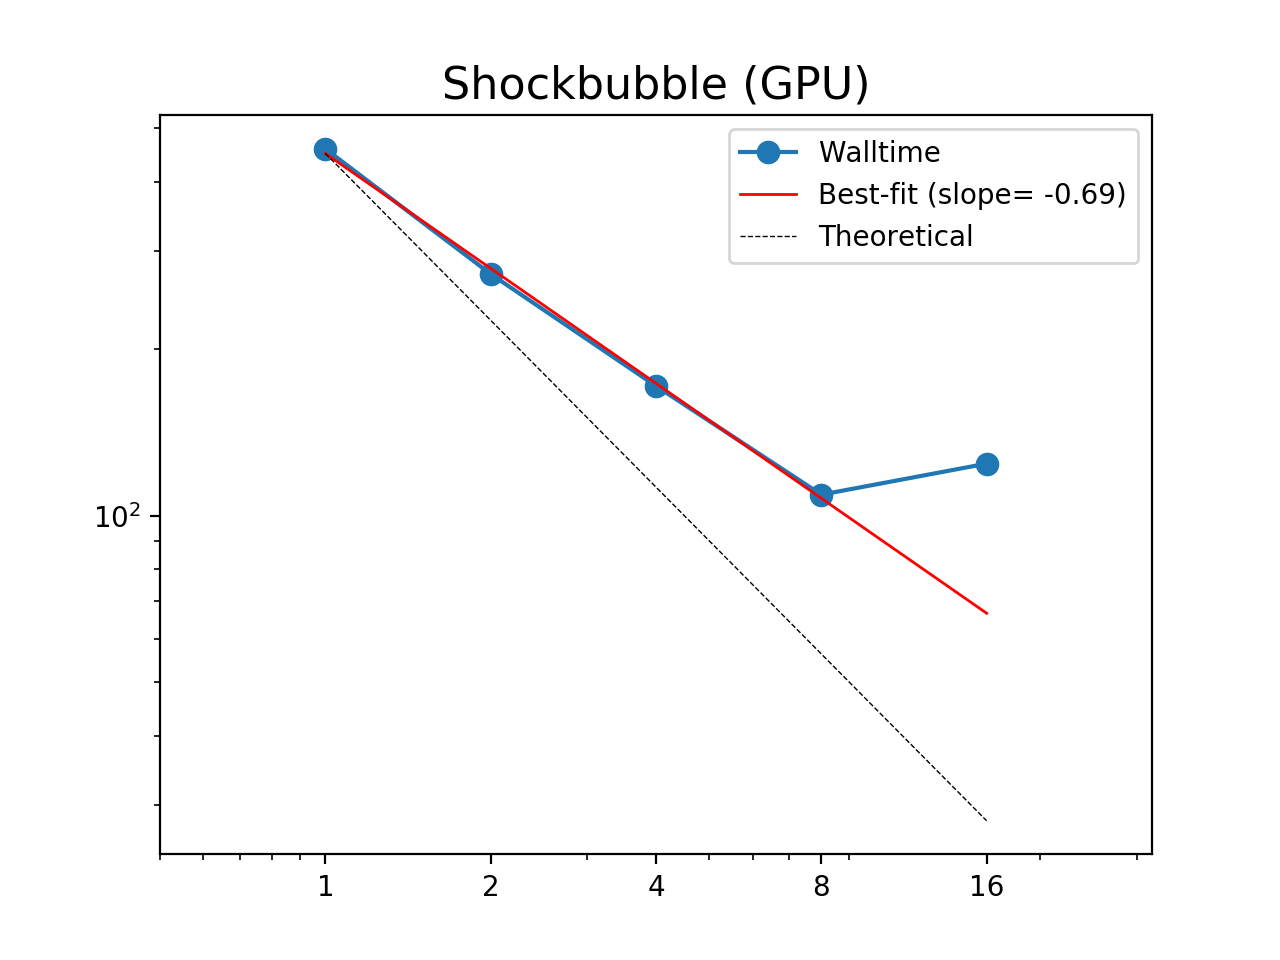

In [33]:
import data_tools

df_gpu = example_data.loc[(example,'GPU'),:]

plt.figure()

data_tools.strong_scaling(df_gpu,'walltime')
plt.title('{:s} (GPU)'.format(example.capitalize()),fontsize=16);


## Efficiency (gpu)

<IPython.core.display.Javascript object>


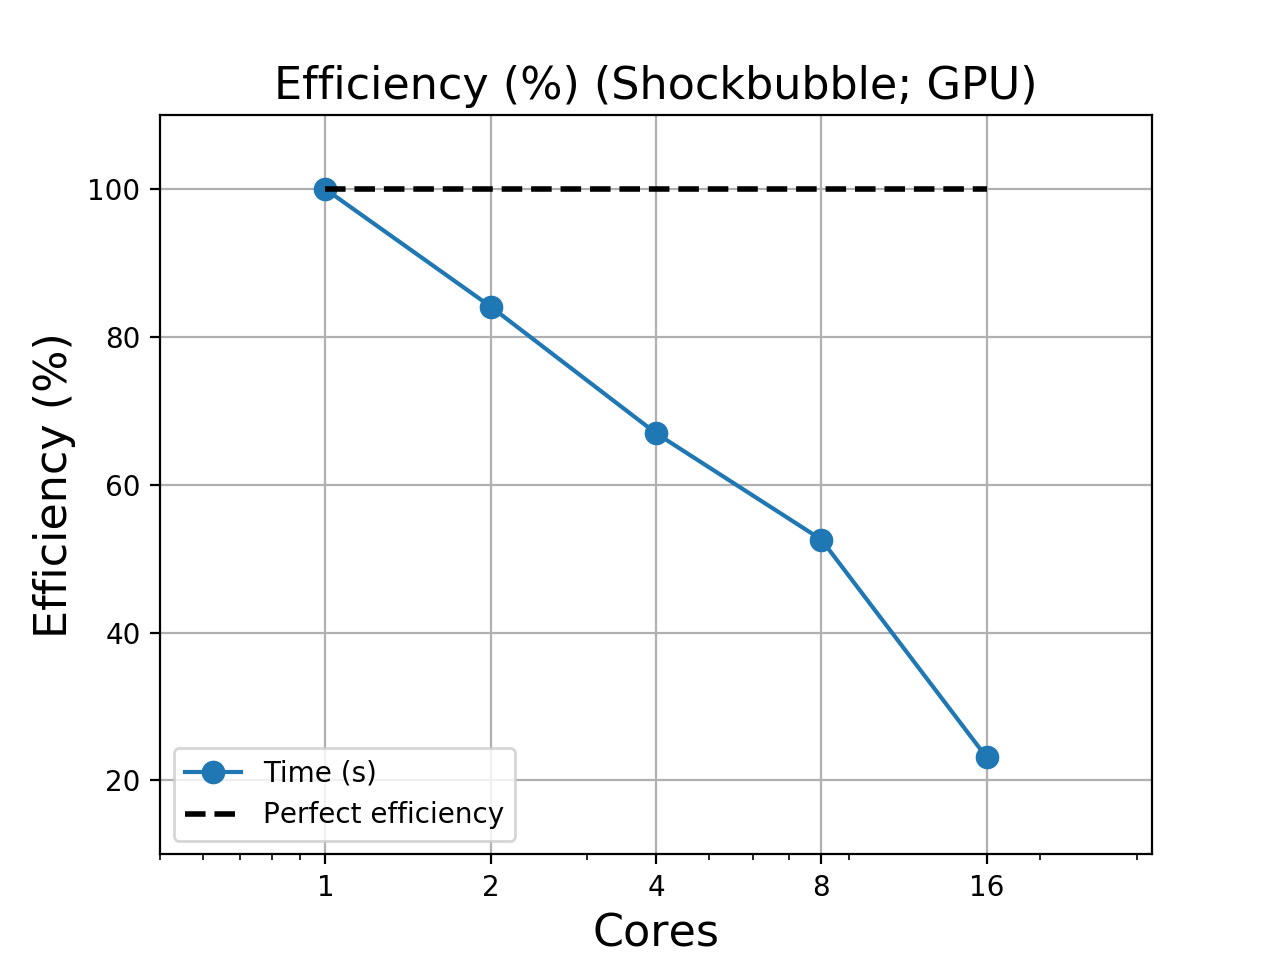

In [34]:
import data_tools
plt.figure()

data_tools.efficiency(df_gpu,'walltime')
data_tools.plt.title('Efficiency (%) ({:s}; GPU)'.format(example.capitalize()),fontsize=16);

## Bar plot (GPU)

<IPython.core.display.Javascript object>


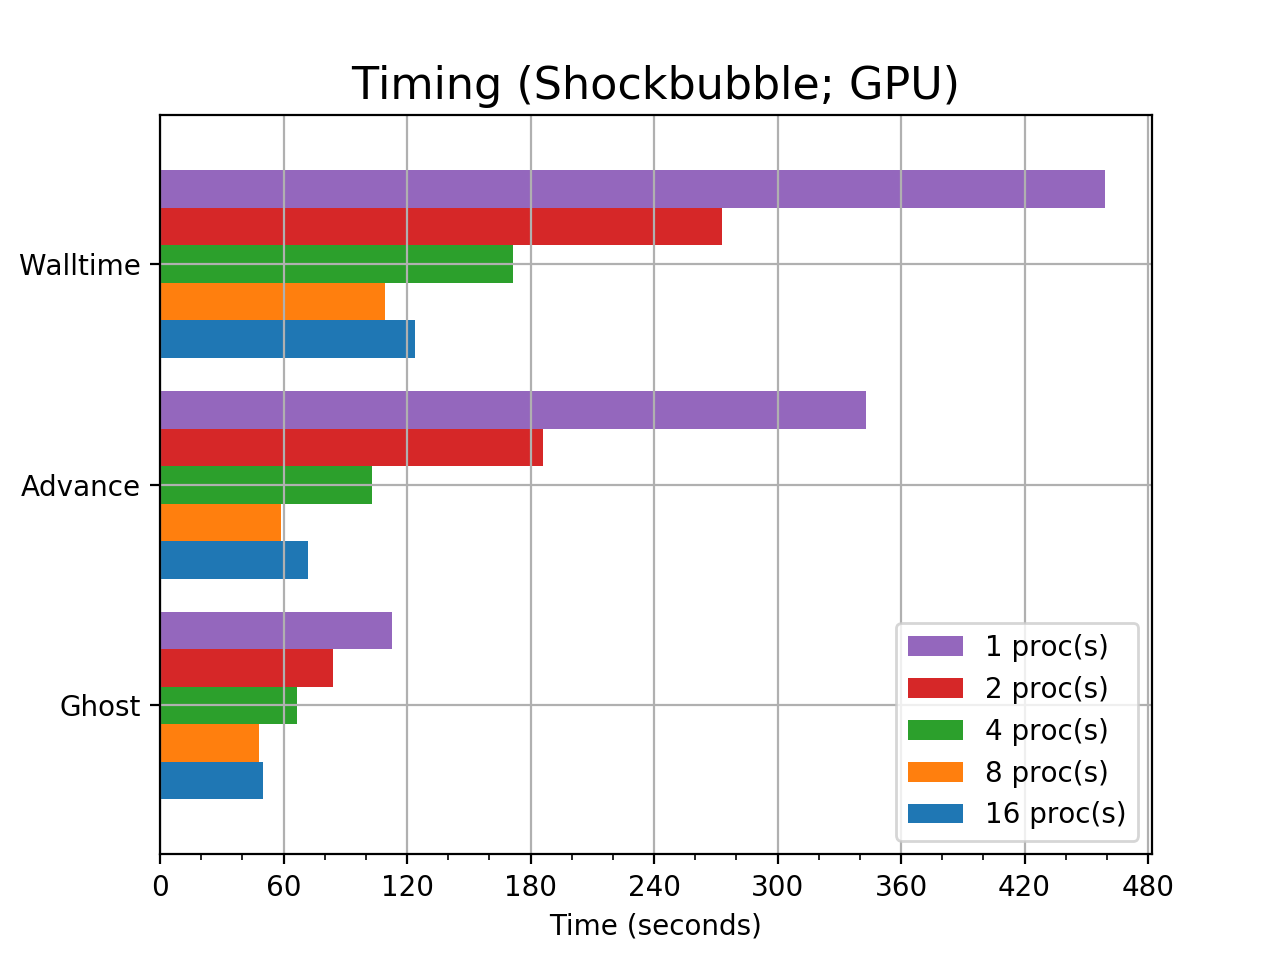

In [38]:
import data_tools

h = data_tools.bar_plot(df_gpu)
data_tools.plt.title('Timing ({:s}; GPU)'.format(example.capitalize()),fontsize=16);

plt = data_tools.plt
ax=data_tools.plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(60))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.MultipleLocator(20))   # Multiples of seconds
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.0f}'.format(value)))

# data_tools.plt.xlim([0,550])

## Stacked bar (GPU)

<IPython.core.display.Javascript object>


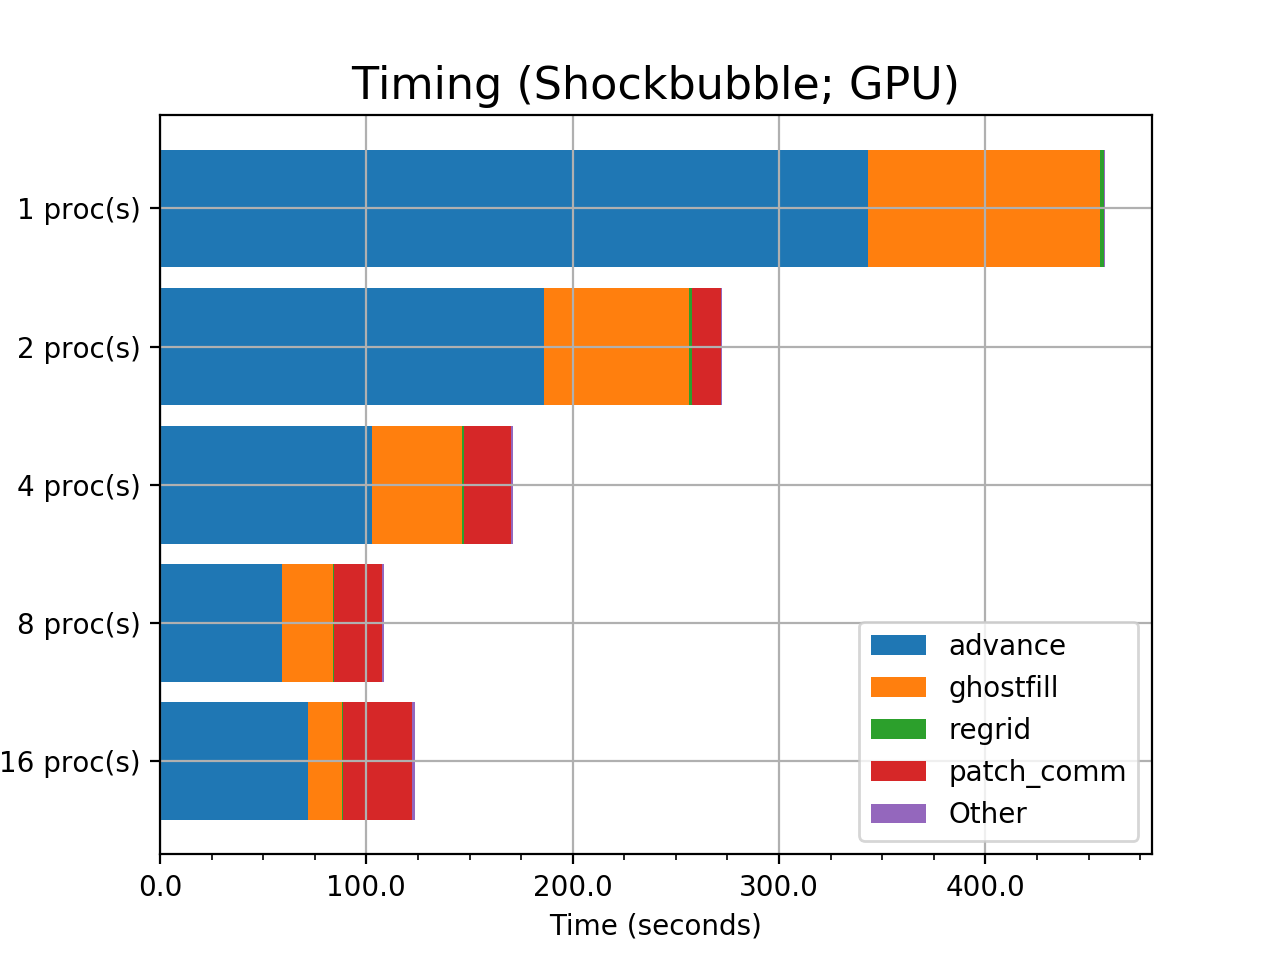

In [39]:
import data_tools

data_tools.barh_plot(df_gpu)

plt = data_tools.plt
ax=data_tools.plt.gca()

ax.xaxis.set_major_locator(plt.MultipleLocator(100))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.MultipleLocator(25))   # Multiples of seconds
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.1f}'.format(value)))

# data_tools.plt.xlim([0,550])
data_tools.plt.title('Timing ({:s}; GPU)'.format(example.capitalize()),fontsize=16);

<hr style="border-width:4px; border-color:coral"/>

# CPU Results

<hr style="border-width:4px; border-color:coral"/>

## Strong scaling (CPU)

<IPython.core.display.Javascript object>


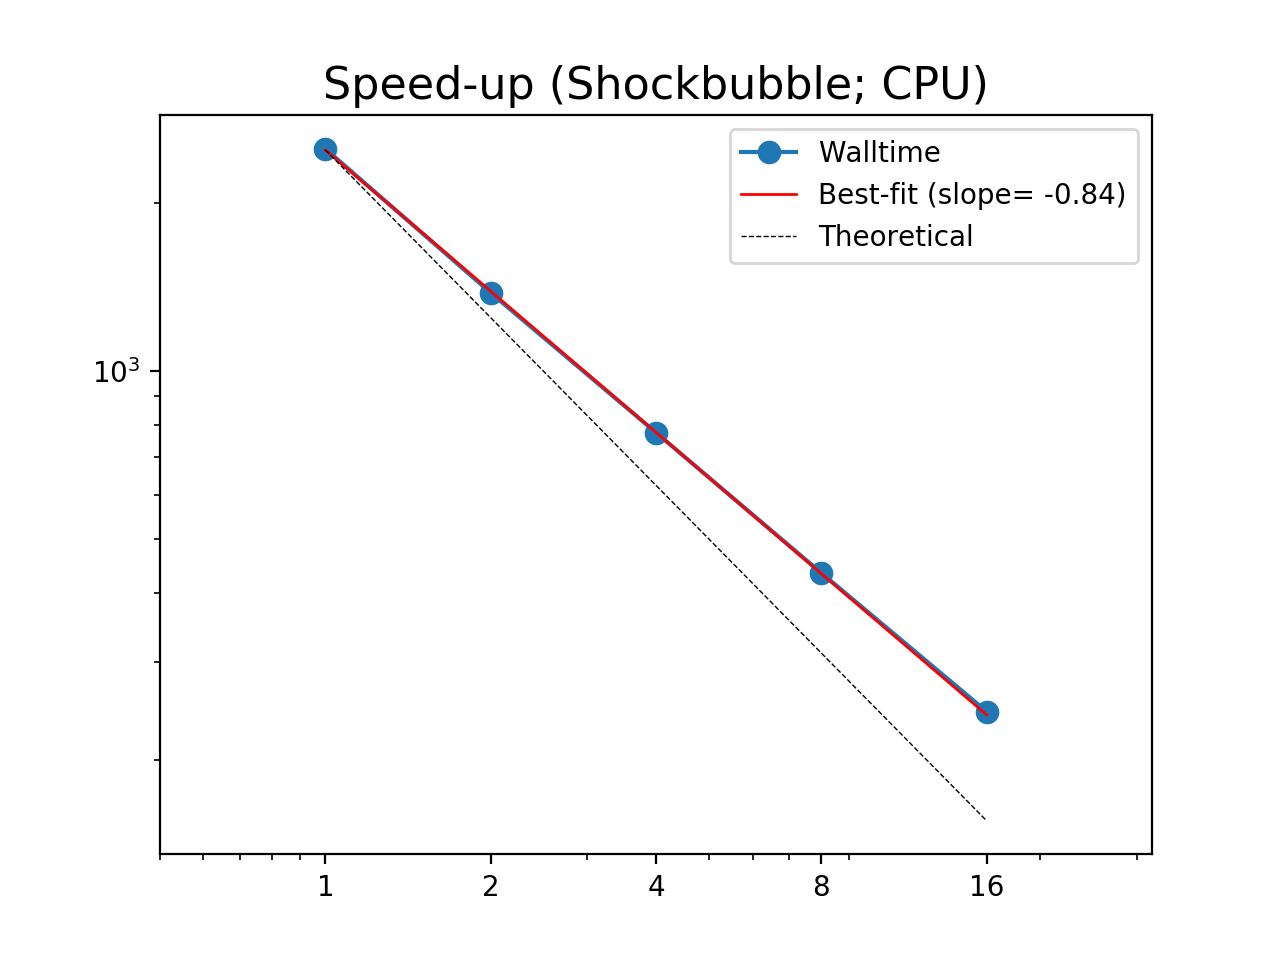

In [40]:
import data_tools
plt.figure()

df_cpu = example_data.loc[(example,'CPU'),:]

data_tools.strong_scaling(df_cpu)
data_tools.plt.title('Speed-up ({:s}; CPU)'.format(example.capitalize()), fontsize=16);

## Efficiency (CPU)

<IPython.core.display.Javascript object>


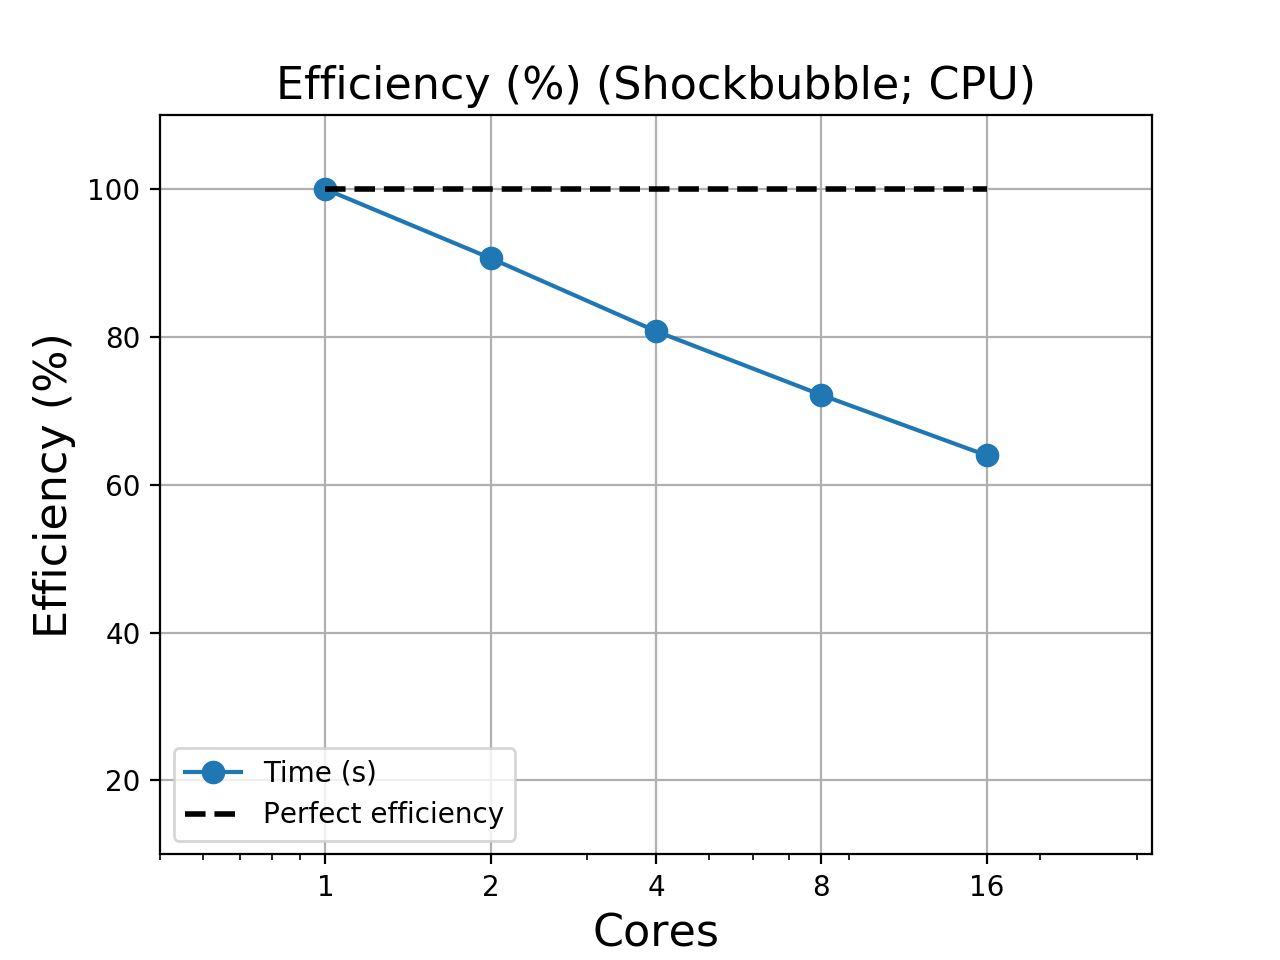

In [41]:
import data_tools

data_tools.plt.figure()
data_tools.efficiency(df_cpu,'walltime')
data_tools.plt.title('Efficiency (%) ({:s}; CPU)'.format(example.capitalize()),fontsize=16);

## Bar plot (CPU)

<IPython.core.display.Javascript object>


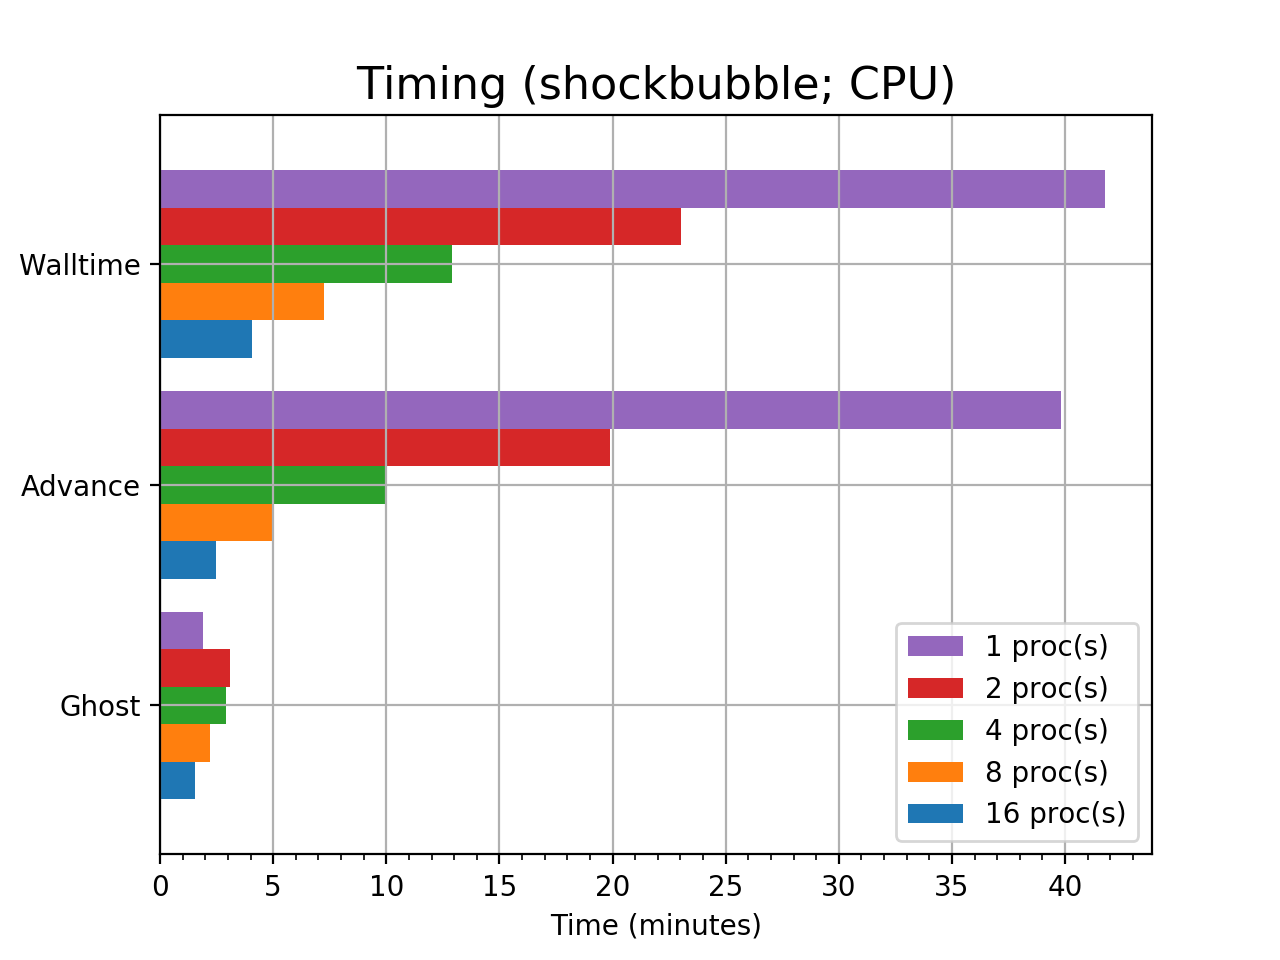

In [42]:
import data_tools

data_tools.bar_plot(df_cpu)
data_tools.plt.title('Timing ({:s}; CPU)'.format(example),fontsize=16);

plt = data_tools.plt
ax=data_tools.plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(5*60))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.MultipleLocator(60))   # Multiples of seconds
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.0f}'.format(value/60)))

# data_tools.plt.xlim([0,1800])
plt.xlabel('Time (minutes)')
plt.show();

## Stacked bar (CPU)

<IPython.core.display.Javascript object>


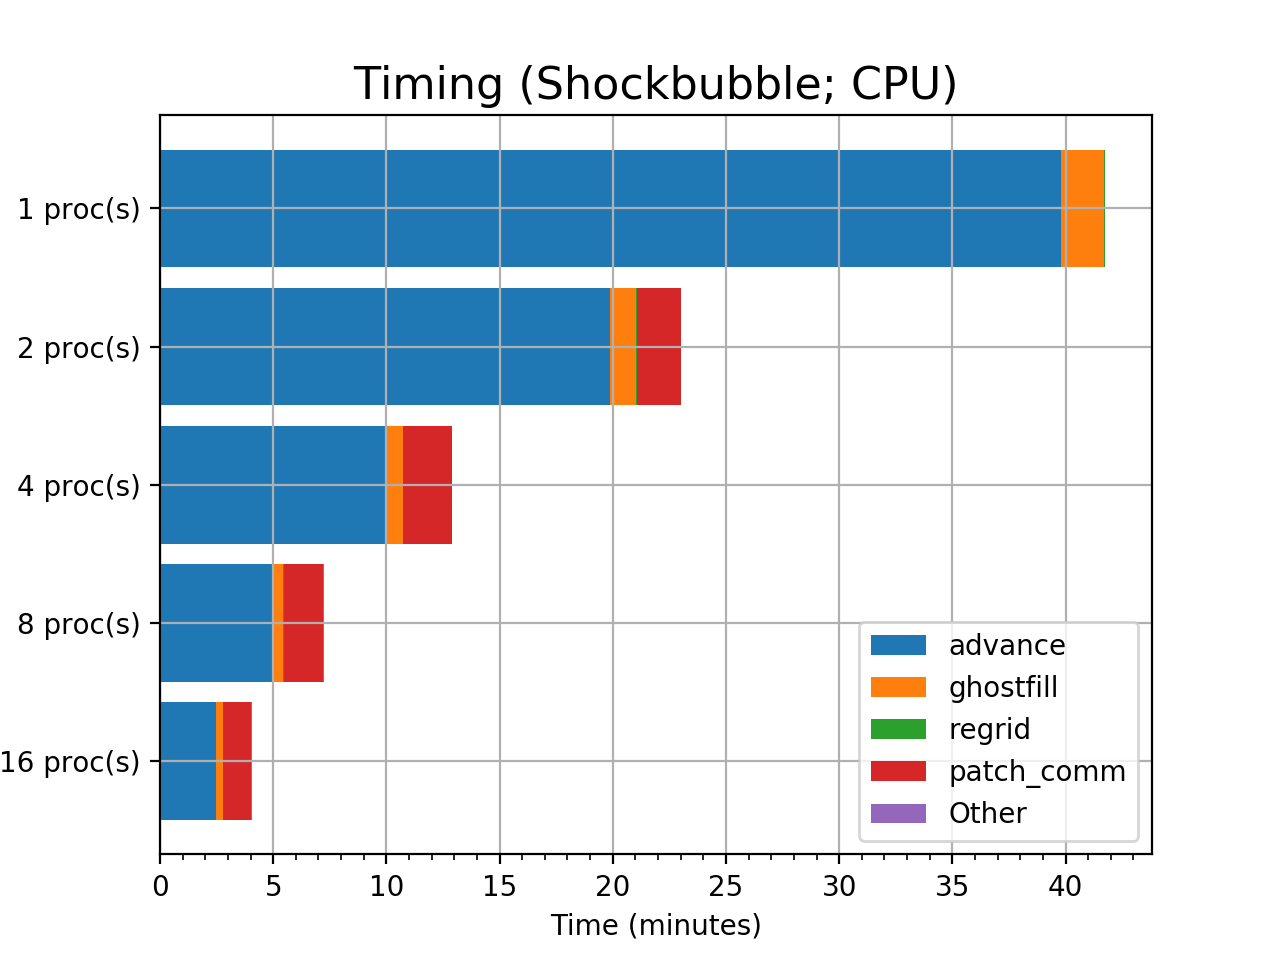

In [43]:
import data_tools

df1 = df_cpu.copy()
data_tools.barh_plot(df1)
data_tools.plt.title('Timing ({:s}; CPU)'.format(example.capitalize()),fontsize=16);

plt = data_tools.plt
ax=data_tools.plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(5*60))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.MultipleLocator(1*60))   # Multiples of seconds
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:.0f}'.format(value/60)))
plt.xlabel('Time (minutes)')
# data_tools.plt.xlim([0,1800])
data_tools.plt.show()

<hr style="border-width:4px; border-color:coral"/>

# Comparisons between CPU and GPU

<hr style="border-width:4px; border-color:coral"/>

<IPython.core.display.Javascript object>


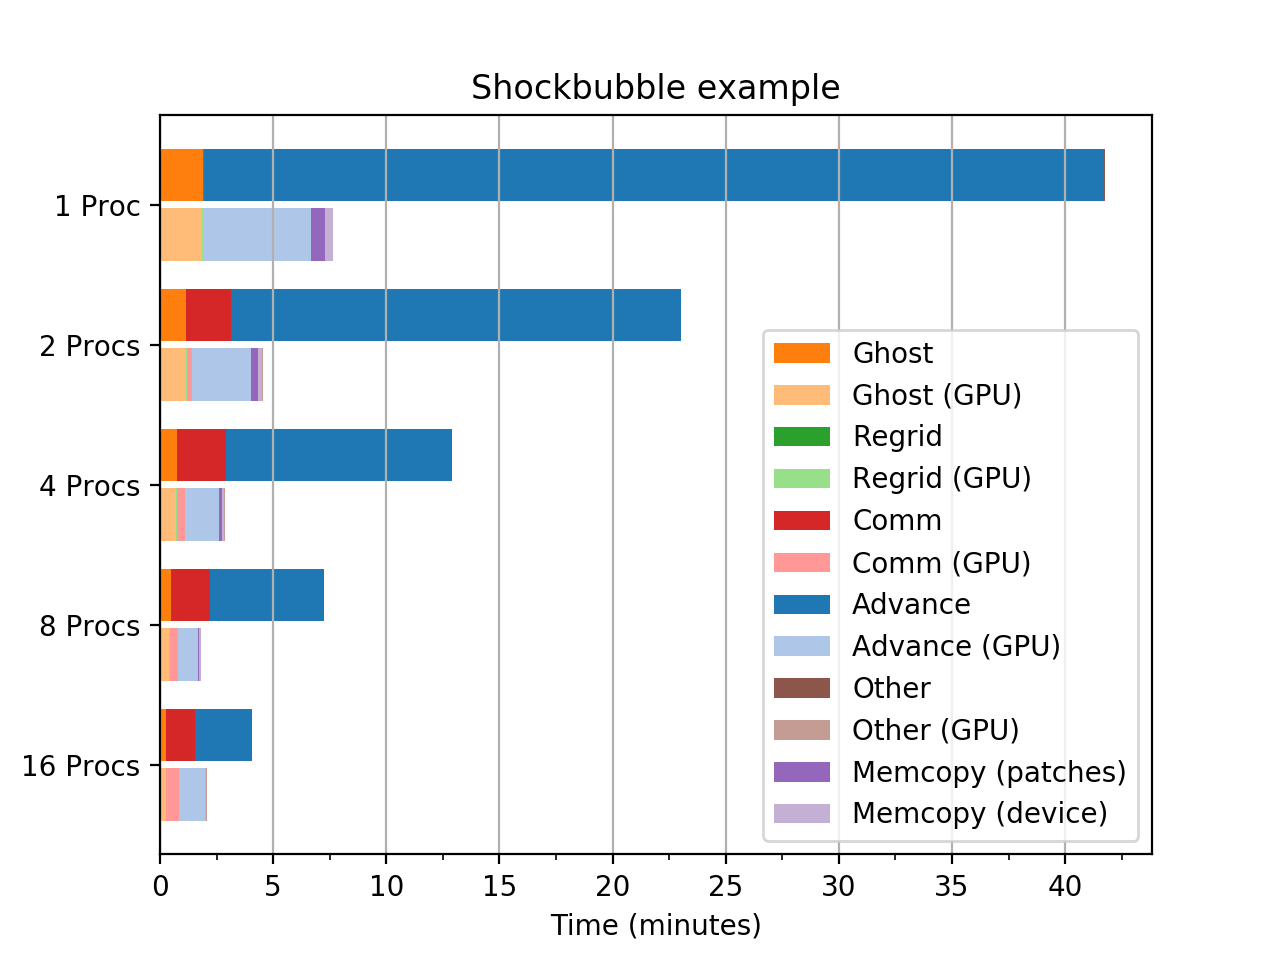

In [44]:
import data_tools
from data_tools import amr_colors
plt.figure()

idx = pandas.IndexSlice
pd = example_data.loc[example].copy()

width = 0.375
d = 0.05

i0 = np.array([0,1,2,3,4])
i1 = list(reversed(i0 + (d + width)/2))
i2 = list(reversed(i0 - (d + width)/2))

ac = 1
ag = 1

plt.grid(axis='x')


# ---------------------------------- bar plots ---------------------------------------

# s_ghost = pd.loc[idx[:,'ghostfill'],:]
# s_ghost.loc[idx[:,'GPU']]

s_ghost =  pd.loc[idx[:,:],'ghostfill']

plt.barh(i1, s_ghost['CPU'], width,color=amr_colors['ghost'][0], label='Ghost')
plt.barh(i2, s_ghost['GPU'], width,color=amr_colors['ghost'][1], label='Ghost (GPU)')
tot = s_ghost.copy()


s_regrid = pd.loc[idx[:,:],'regrid']
plt.barh(i1, s_regrid['CPU'], width,color=amr_colors['regrid'][0], left=tot['CPU'], label='Regrid')
plt.barh(i2, s_regrid['GPU'], width,color=amr_colors['regrid'][1], left=tot['GPU'], label='Regrid (GPU)')
tot += s_regrid

s_comm =  pd.loc[idx[:,:],'patch_comm']
plt.barh(i1, s_comm['CPU'], width,color=amr_colors['comm'][0], left=tot['CPU'], label='Comm')
plt.barh(i2, s_comm['GPU'], width,color=amr_colors['comm'][1], left=tot['GPU'], label='Comm (GPU)')
tot += s_comm

s_adv = pd.loc[idx[:,:],'advance']
plt.barh(i1, s_adv['CPU'], width,color=amr_colors['advance'][0], left=tot['CPU'],label='Advance')
plt.barh(i2, s_adv['GPU'], width,color=amr_colors['advance'][1], left=tot['GPU'],label='Advance (GPU)')
tot += s_adv.copy()

s_other = pd.loc[idx[:,:],'walltime'] - tot - pd.loc[idx[:,:],'output']
plt.barh(i1, s_other['CPU'], width,color=amr_colors['other'][0], left=tot['CPU'], \
         label='Other')
plt.barh(i2, s_other['GPU'], width,color=amr_colors['other'][1], left=tot['GPU'], label='Other (GPU)')
tot += s_other

s_last = s_other

# Add memcopy info
s_h2h = pd.loc[idx[:,:],'memcopy_h2h']
s_dev = pd.loc[idx[:,:],'memcopy_h2d'] + pd.loc[idx[:,:,],'memcopy_d2h']
l_h2h =  tot['GPU'] - s_last['GPU'] - s_h2h['GPU'] - s_dev['GPU'];
l_dev = l_h2h + s_h2h['GPU']

plt.barh(i2, s_h2h['GPU'], width, fill=True, edgecolor=None, color=amr_colors['memcopy'][0],\
          alpha=1,left = l_h2h, label='Memcopy (patches)')

plt.barh(i2, s_dev['GPU'], width, fill=True, edgecolor=None, color=amr_colors['memcopy'][1], \
          alpha=1, left = l_dev, linewidth=0.5,label='Memcopy (device)')


# ---------------------------------- Tick marks, legend ---------------------------------------
plt = data_tools.plt
ax=data_tools.plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(5*60))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.MultipleLocator(2.5*60))   # Multiples of seconds
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number : '{:0.0f}'.format(value/60)))

ax.yaxis.set_major_locator(plt.FixedLocator(i0, nbins=None))
ax.set_yticklabels(reversed(['1 Proc','2 Procs','4 Procs','8 Procs','16 Procs']))

plt.title('{:s} example'.format(example.capitalize()))
plt.xlabel('Time (minutes)')
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


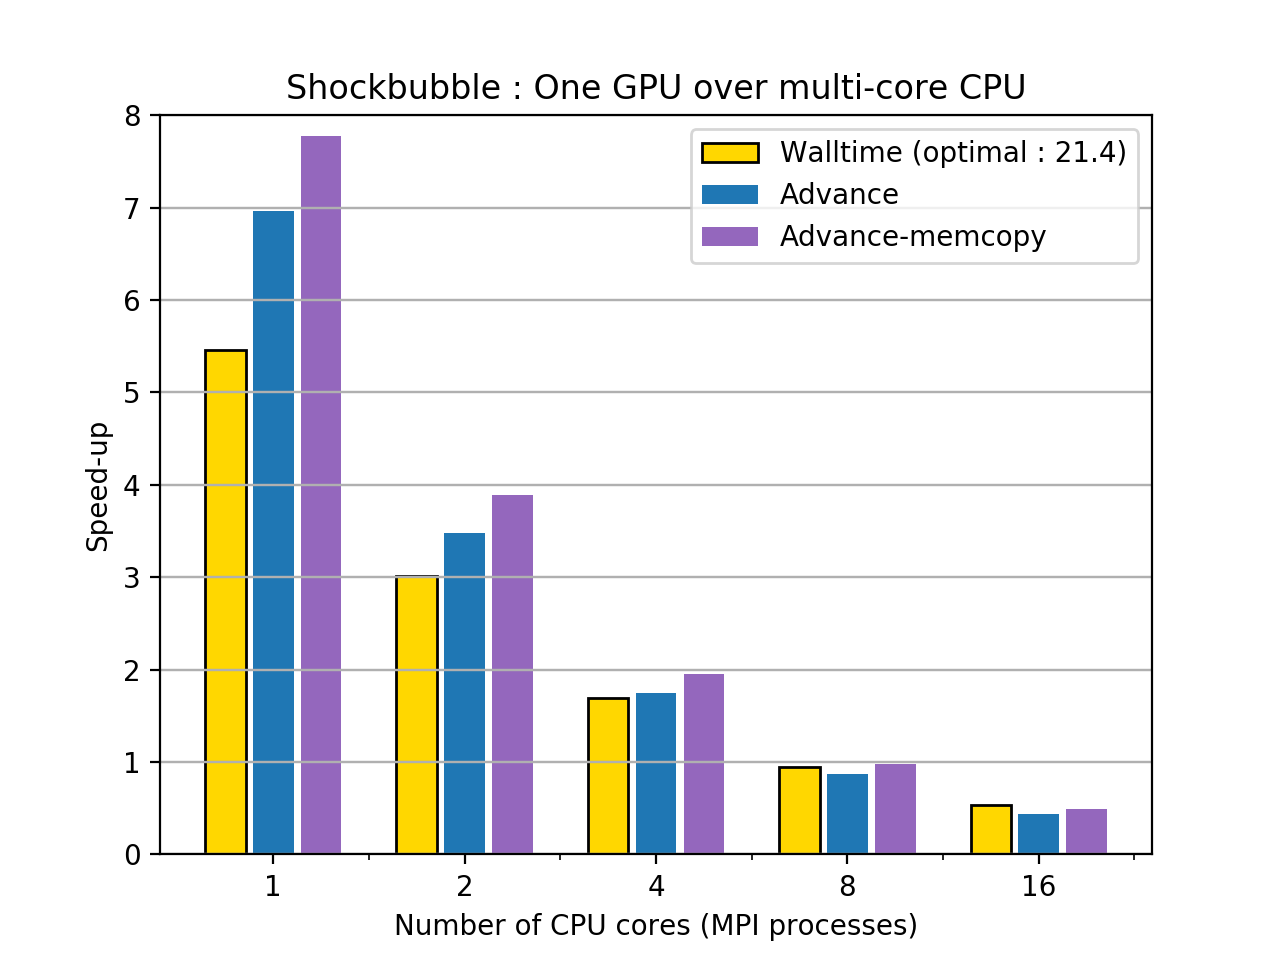

In [45]:
idx = pandas.IndexSlice
pd = example_data.loc[example].copy()

mode = 'other'   # 'redhawk'
s_wall = pd["walltime"] - pd["output"]  # Series

if mode is 'one2one':
    # example_data.loc[idx[:,'GPU'],'ghostfill']
    speed_up_wall = s_wall["CPU"]/s_wall["GPU"]    
    speed_up_adv = pd.loc['CPU','advance']/pd.loc['GPU','advance']
    speed_up_adv_memcopy = pd.loc['CPU','advance']/(pd.loc['GPU','advance']-pd.loc['GPU','memcopy_h2h'])
    procs = [1,2,4,8,16]
elif mode is 'redhawk':
    speed_up_wall = s_wall["CPU"]/s_wall["GPU",1]    
    speed_up_adv = (pd.loc['CPU','advance'])/pd.loc[('GPU',1),'advance']
    memcpy = pd.loc[('GPU',1),'memcopy_h2h'] # + pd.loc[1,'memcopy_h2d'] + pd.loc[1,'memcopy_d2h']
    speed_up_adv_memcopy = pd.loc['CPU','advance']/(pd.loc[('GPU',1),'advance']-memcpy)
    procs = [1,2,4,8,16]
else:
    speed_up_wall = s_wall['CPU']/s_wall[('GPU',1)]    
    speed_up_adv = (pd.loc['CPU','advance'])/pd.loc[('GPU',1),'advance']
    memcpy = pd.loc[('GPU',1),'memcopy_h2h'] # + pd.loc[0,'memcopy_h2d'] + pd.loc[0,'memcopy_d2h']
    speed_up_adv_memcopy = pd.loc['CPU','advance']/(pd.loc[('GPU',1),'advance']-memcpy)
    procs = [1,2,4,8,16]
    

# Compute optimal speed-up
pct_advance = pd.loc['CPU','advance'][1]/pd.loc['CPU','walltime'][1]
optimal = 1/(1-pct_advance)    

width = 0.85
d = 1 - width
total_bars = 3   # bars per proc group
total_width = len(procs)*total_bars*(width + d)

i0 = np.arange(0,(total_bars+1)*len(procs),total_bars+1)
w = (width+d)/2.0
i1 = list(i0 - (total_bars//2) )
i2 = list(i0 )
i3 = list(i0 + (total_bars)//2)

plt.figure()



plt.bar(i1,speed_up_wall,color='gold',edgecolor='k', linewidth=1, width=width, \
               label='Walltime (optimal : {:.1f})'.format(optimal))
plt.bar(i2,speed_up_adv,color=amr_colors['advance'][0],width=width,label='Advance')
plt.bar(i3,speed_up_adv_memcopy,color=amr_colors['memcopy'][0],width=width,label='Advance-memcopy')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.FixedLocator(i0))   # Multiples of seconds
ax.xaxis.set_minor_locator(plt.FixedLocator([2,6,10,14,18]))   # Multiples of seconds

ax.set_xticklabels(procs)

ax.yaxis.set_major_locator(plt.MultipleLocator(1))   # Multiples of seconds
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))   # Multiples of seconds

if mode is 'one2one':
    plt.title('{:s} : Speed-up : GPU vs. CPU'.format(example.capitalize()))
elif mode is 'redhawk':
    plt.title('{:s} : 2 GPUs over 4 CPUs (Redhawk)'.format(example.capitalize()))
else:
    plt.title('{:s} : One GPU over multi-core CPU'.format(example.capitalize()))

plt.xlabel('Number of CPU cores (MPI processes)')
plt.ylabel('Speed-up')

# xl = ax.get_xlim();
# plt.plot([-1,20],np.array([[optimal],[optimal]]),color='darkgrey',linewidth=4,label='optimal speed-up')
    
    
plt.ylim([0, 8])
plt.grid(axis='y', which='both')    
plt.legend(loc='upper right')


plt.show()

In [ ]:
(pd.loc['CPU','advance'])/pd.loc[('GPU',1),'advance']